In [1]:
import torch 
import logging
import random 
from mlca_for_elec.networks.main import eval_config
import os
import matplotlib.pyplot as plt
from mlca_for_elec.env.env import Microgrid, HouseHold
from mlca_for_elec.mlca_elec.mlca import *
import json
import numpy as np
from collections import defaultdict
import pandas as pd

Class NN_MIP_TORCH imported
Class MLCA_WDP imported
Class MLCA_Economies imported
FUNCTION MLCA imported


In [2]:
os.getcwd()
os.chdir("c:\\Users\\pieples\\Documents\\MLICA-for-elec\\")

In [3]:
exp_number = 1

In [4]:
household_path = f"config\experiment{exp_number}\households"
microgrid_path = f"config\experiment{exp_number}\microgrid\exp{exp_number}_microgrid.json"
dataset_path = f"config\experiment{exp_number}\dataset"

In [5]:
%matplotlib inline
print("Start loading household profiles")
folder_path = household_path
houses = []
for file in os.listdir(folder_path)[:3]:
    if file.endswith(".json"):
        household = json.load(open(folder_path+"/"+ file))
    house = HouseHold(household, horizon =1)

    generation_path = "data\solar_prod\Timeseries_55.672_12.592_SA2_1kWp_CdTe_14_44deg_-7deg_2020_2020.csv"
    consumption_path = f"data/consumption/Reference-{house.param['consumption']['type']}.csv"
    spot_price_path = "data/spot_price/2020.csv"
    fcr_price_path = "data/fcr_price/random_fcr.csv"
    profile_path_train = dataset_path + f"/dataset_{house.ID}.csv"
    profile_path_valtest = dataset_path + f"/test_dataset_{house.ID}.csv"
    house.load_data(generation_path,consumption_path, spot_price_path,fcr_price_path, profile_path_train, profile_path_valtest,type = float)
    for i in range(0):
        house.next_data()
    houses.append(house)
print(f"Loaded {len(houses)} households")
print("Start compute social welfare")
print(list(houses[0].data['consumption'].to_numpy()))
microgrid_1 =json.load(open( microgrid_path))
MG = Microgrid(houses, microgrid_1)
optimal_allocation = {}
for house in MG.households:
    print(house.data['consumption'].sum())
    optimal_allocation_tuple = MG.get_efficient_allocation()
    optimal_allocation[house.ID] = (optimal_allocation_tuple[0][house.ID] , MG.calculate_value(house.ID, optimal_allocation_tuple[0][house.ID]))
MG.generate_dataset(0,dataset_path,1000)
MG.generate_test_dataset(0,dataset_path,1000)

Start loading household profiles
0


1
2
Loaded 3 households
Start compute social welfare
[1.3486959329357744]
1.3486959329357744
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.47009925686207
  Upper bound: 0.47009925686207
  Number of objectives: 1
  Number of constraints: 36
  Number of variables: 32
  Number of nonzeros: 75
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.13236331939697266
# -----

100%|██████████| 1000/1000 [00:00<00:00, 5715.74it/s]

-----------------------------------
Generating test dataset
-----------------------------------
Generating test dataset for bidder 0
Optimal allocation is : 


0.13486959329357745


100%|██████████| 1000/1000 [00:00<00:00, 6266.03it/s]


In [6]:
df = pd.read_csv("config\experiment1\dataset\dataset_1.csv")
df

,Unnamed: 0,0,1,2,3,4,5,value
0,0,3.937449,3.727817,2.516272,2.603639,2.774067,0.370565,1.289214
1,1,3.161363,2.063279,1.870117,1.954225,3.523567,3.149503,1.745692
2,2,0.501057,3.220460,0.857788,3.479591,2.592845,3.878073,1.538101
3,3,1.992918,2.456589,2.974973,1.194818,1.803119,3.942399,1.745692
4,4,1.593899,0.824048,3.484309,1.818884,1.190061,0.434043,1.175536
...,...,...,...,...,...,...,...,...
995,995,2.052129,2.869933,1.746436,0.564885,1.369617,1.622482,1.410668
996,996,1.388131,2.755270,0.873783,2.677838,2.783378,3.554798,1.711167
997,997,3.568907,1.193323,1.470002,2.680135,3.735022,0.812311,1.377737
998,998,2.003616,0.627322,2.235652,1.542521,0.188148,3.239647,1.379094


In [7]:
x = np.linspace(0, 5, 1000)
y = [MG.calculate_value(1, i) for i in x]



In [8]:
def evaluate_network(cfg: dict, seed: int, MicroGrid_instance: str, bidder_id: str, num_train_data: int, layer_type: str,
                     normalize: bool, normalize_factor: float, eval_test=False, save_datasets=False):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return eval_config(
        seed=seed, SAT_instance=MicroGrid_instance, bidder_id=bidder_id,
        layer_type=layer_type, batch_size=cfg['batch_size'], num_hidden_layers=cfg['num_hidden_layers'],
        num_hidden_units=int(max(1, np.round(cfg['num_neurons'] / cfg['num_hidden_layers']))), l2=cfg['l2'], l1 = 0,
        lr=cfg['lr'], normalize_factor=normalize_factor, optimizer=cfg['optimizer'], num_train_data=num_train_data,plot=True,
        eval_test=True, epochs=cfg['epochs'], loss_func=cfg['loss_func'], normalize=normalize, save_datasets=False, log_path="logs")

Selected hyperparameters {'batch_size': 1, 'epochs': 1000, 'l2': 1e-05, 'loss_func': 'F.l1_loss', 'lr': 0.0001, 'num_hidden_layers': 1, 'num_neurons': 10, 'optimizer': 'Adam'}
Dataset size : Train (10, 1), Val (200, 1), Test (800, 1)
(10, 1) (10,) (200, 1) (200,) (800, 1) (800,)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:10<00:00, 93.57it/s]


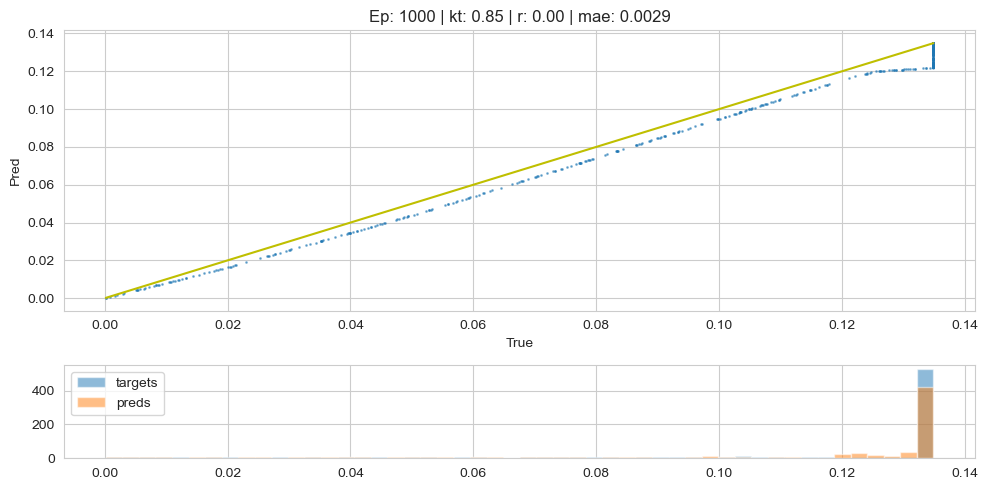

Train metrics 	| pearson corr.: 0.990, KT: 0.728
Valid metrics 	| pearson corr.: 0.000, KT: 0.877
Test metrics 	| pearson corr.: 0.000, KT: 0.849


In [108]:
config_dict = {"batch_size": 1,
        "epochs":1000,
        "l2": 1e-5,
        "loss_func": "F.l1_loss",
        "lr": 0.0001,
        "num_hidden_layers":1,
        "num_neurons": 10,
        "optimizer": "Adam"
    }

print('Selected hyperparameters', config_dict)
model_mvnn, logs = evaluate_network(
    config_dict, seed=0, MicroGrid_instance=MG, bidder_id=0,
    num_train_data=10, layer_type="CALayerReLUProjected",
    normalize=True,
    normalize_factor=1)

train_logs = logs['metrics']['train'][config_dict['epochs']]
val_logs = logs['metrics']['val'][config_dict['epochs']]
test_logs = logs['metrics']['test'][config_dict['epochs']]

print('Train metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(train_logs['r'], train_logs['kendall_tau']))
print('Valid metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(val_logs['r'], val_logs['kendall_tau']))

print('Test metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(test_logs['r'], test_logs['kendall_tau']))

Selected hyperparameters {'batch_size': 1, 'epochs': 1000, 'l2': 1e-12, 'loss_func': 'F.l1_loss', 'lr': 0.0001, 'num_hidden_layers': 3, 'num_neurons': 20, 'optimizer': 'Adam'}
Dataset size : Train (20, 1), Val (200, 1), Test (800, 1)
(20, 1) (20,) (200, 1) (200,) (800, 1) (800,)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:43<00:00, 23.24it/s]


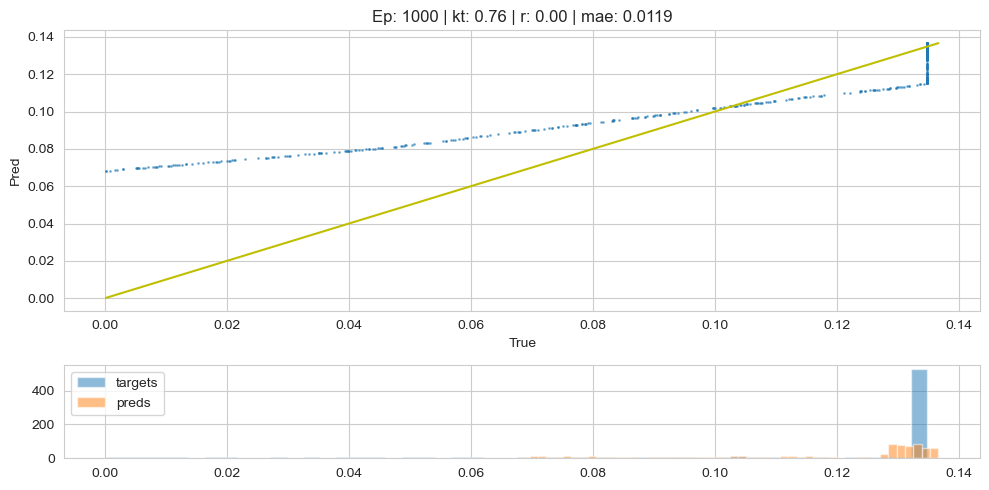

Train metrics 	| pearson corr.: 0.975, KT: 0.669
Valid metrics 	| pearson corr.: 0.000, KT: 0.781
Test metrics 	| pearson corr.: 0.000, KT: 0.759


In [154]:
config_dict = {"batch_size": 1,
        "epochs":1000,
        "l2": 1e-12,
        "loss_func": "F.l1_loss",
        "lr": 0.0001,
        "num_hidden_layers":3,
        "num_neurons": 20,
        "optimizer": "Adam"
    }

print('Selected hyperparameters', config_dict)
model_plainnn, logs = evaluate_network(
    config_dict, seed=0, MicroGrid_instance=MG, bidder_id=0,
    num_train_data=20, layer_type="PlainNN",
    normalize=True,
    normalize_factor=1)

train_logs = logs['metrics']['train'][config_dict['epochs']]
val_logs = logs['metrics']['val'][config_dict['epochs']]
test_logs = logs['metrics']['test'][config_dict['epochs']]

print('Train metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(train_logs['r'], train_logs['kendall_tau']))
print('Valid metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(val_logs['r'], val_logs['kendall_tau']))

print('Test metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(test_logs['r'], test_logs['kendall_tau']))

In [155]:
best_model = model_plainnn

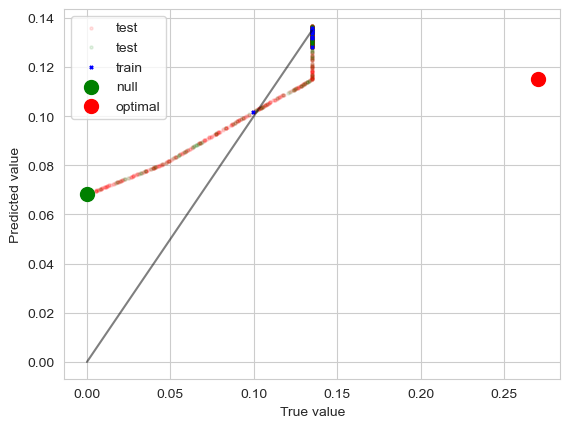

In [156]:
profile_train = pd.read_csv(f"config\experiment{exp_number}\dataset/dataset_0.csv")
bids = profile_train.to_numpy()[:,1:-1]
value = profile_train.to_numpy()[:,-1]
n_item = 10
normalize_factor = 1
bids_train = torch.Tensor(bids[:n_item])
target_train = value[:n_item]
target_max = target_train.max()* (1 /1)
n_item = 1000000
profile_test = pd.read_csv(f"config\experiment{exp_number}\dataset/test_dataset_0.csv", nrows = n_item)
bids = profile_test.to_numpy()[:,1:-1]
value = profile_test.to_numpy()[:,-1]

bids_val = torch.Tensor(bids)[:int(len(bids)*0.2)]
target_val = value[:int(len(bids)*0.2)]

bids_test = torch.Tensor(bids)[int(len(bids)*0.2):]
null_test = torch.zeros_like(bids_test[1])
target_test = value[int(len(bids)*0.2):]




# Scale targets
target_train = target_train /target_max
target_val = target_val /target_max
target_test = target_test /target_max


pred_train = best_model(bids_train)
pred_val = best_model(bids_val)
pred_test = best_model(bids_test)
pred_null = best_model(null_test)

#plt.xlim(-0.1, target_max*1.1)#
# plt.ylim(-0.1, target_max*1.1)#
dat_min, dat_max = min(min(pred_train), min(target_train)), \
                           max(max(pred_train), max(target_train))
plt.plot([0,target_train.max()*target_max], [0, normalize_factor*target_max], color = "black", alpha=0.5)
#plt.plot([dat_min, dat_max], [dat_min, dat_max], 'y')
plt.scatter(target_test*target_max, pred_test.detach().numpy()*target_max, label = "test", marker="o", color = "r", alpha=0.1,s=5)
plt.scatter(target_val*target_max, pred_val.detach().numpy()*target_max, label = "test", marker="o", color = "g", alpha=0.1,s=5)
# plt.scatter(target_synth*target_max, pred_synth.detach().numpy()*target_max, marker="o", color = "r", alpha =0.1, s=5)
plt.scatter(target_train*target_max, pred_train.detach().numpy()*target_max, label = "train", marker="x", color = "b", s=5)
plt.scatter(0, pred_null.detach().numpy()*target_max, label = "null", marker="o", color = "g", s=100)
plt.scatter(optimal_allocation[1][1],  best_model(torch.Tensor(optimal_allocation[1][0])).detach().numpy()*target_max, label = "optimal", marker="o", color = "r", s=100)
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.legend()
plt.show()

In [157]:
x = np.linspace(0, 5, 100)
y = [MG.calculate_value(0, i) for i in x]
y_plainnn = [model_plainnn(torch.Tensor([i])).detach().numpy()*target_max for i in x]
y_mvnn = [model_mvnn(torch.Tensor([i])).detach().numpy()*target_max for i in x]
bids_train, value.squeeze()[:10].shape

(tensor([[3.5537],
         [3.5527],
         [2.6708],
         [2.7545],
         [3.4929],
         [0.9976],
         [3.7648],
         [1.6785],
         [3.1875],
         [3.3701]]),
 (10,))

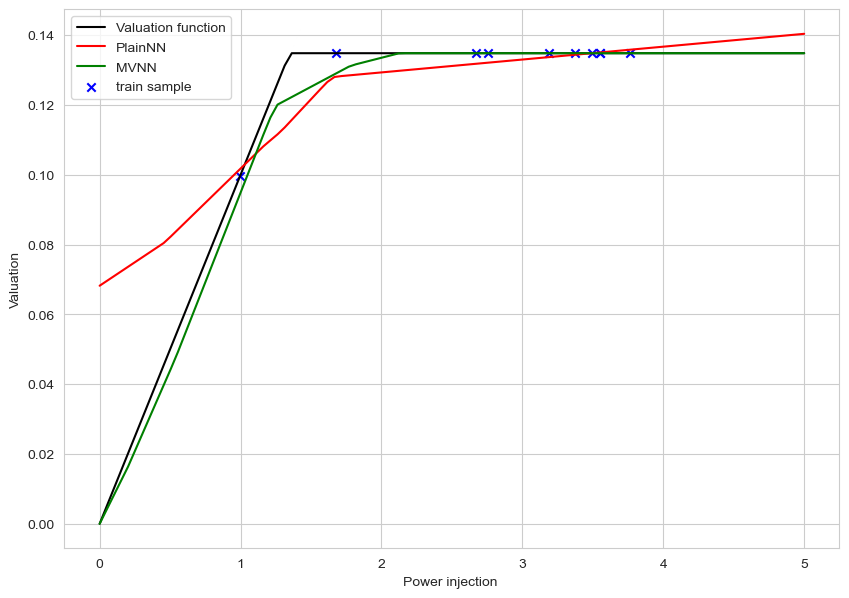

In [160]:
plt.figure(figsize=(10,7))
plt.plot(x,y, label = "Valuation function", color = "black")
plt.plot(x,y_plainnn, label = "PlainNN", color = "r")
plt.plot(x,y_mvnn, label = "MVNN", color = "g")
plt.scatter(bids_train,target_train*target_max, marker = "x", color = "b", label = "train sample")
plt.xlabel("Power injection ")
plt.ylabel("Valuation")
plt.legend()